In [108]:
# %pip install healpy
# %pip install astropy
# %pip install tqdm
import healpy as hp
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from tqdm import tqdm

### Get Z-bin Values

This code will accept a z-value as a parameter and return the index of the corresponding z-bin. The z-bin values are from Tomographer (the file 'ddz-4.csv' is the output from one of the dust map runs, and I just stripped the z-values from the x-axis. The z-bins were the same for all of the dust maps and galaxy catalogs I have ran on Tomographer, so I believe they are fixed).

In [109]:
# get z-bin values
z_bins = pd.read_csv('ddz-4.csv')
z_bins = z_bins['z']

### Get Galaxy Data

We read in the data for the galaxies. The data info we care about is pixel location (@ nside=2048), z-value, and z-bin

In [110]:
# Read in 22.5 million data elements
data = pd.read_csv('GLADE+_2048.csv')
# gives only galaxies in our redshift bin
data = data.loc[(data.Z > 0) & (data.Z < np.max(z_bins))]

In [111]:
# I use parallel arrays to get around using data.iloc[i] repeatedly
pixels = data.Pix
z = data.Z
z_bin = data.Z_bin
# I accidentally saved my bins as floats -- can't use an index
# will fix, but for now just casting
data.astype({'Z_bin': 'int32'}).dtypes

Unnamed: 0      int64
Pix             int64
Z             float64
Z_bin           int32
dtype: object

### Get E(B-V) and <E(B-V)>

The value at a given pixel in the intensity map represents E(B-V), the value at a given pixel in the intensity map smoothed to 1 degree represents <E(B-V)> 

In [112]:
# set map resolution
nside = 2048

# read in dust model map
dust_map = hp.read_map('d10_2048_353_I.fits')

npixels = len(dust_map)

# dust map smoothed to 1 degree
smooth_dust_map = hp.sphtfunc.smoothing(dust_map, fwhm=0.0174533, iter=1)

### Use Histograms to Create Galaxy Maps for each Redshift Bin ( N )

In [114]:
n_gal = len(data)
n_zbins = len(z_bins)

# create a blank map for each z-bin
z_maps = []

bins = np.arange(npixels + 1)

for i in tqdm(range(n_zbins)):
    pix_for_zbin_i_gal = pixels[z_bin == i]
    N_galaxies_in_zbin_i_in_each_pixel, bin_edges = np.histogram(pix_for_zbin_i_gal, bins=bins)
    z_maps.append(N_galaxies_in_zbin_i_in_each_pixel)

100%|███████████████████████████████████████████| 26/26 [05:13<00:00, 12.05s/it]


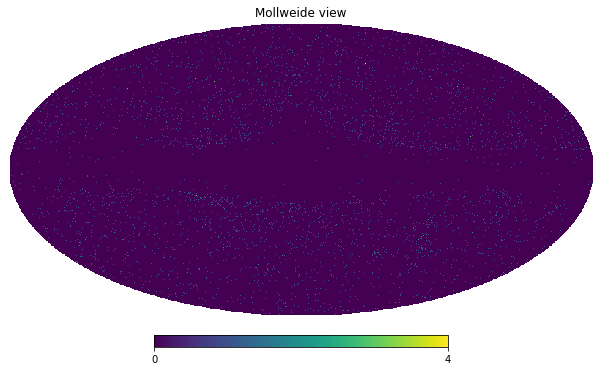

In [115]:
hp.mollview(z_maps[0])

### Make Paralell Galaxy Maps Smoothed to 1 Square Degree ( <'N'> )

In [116]:
smooth_z_maps = []
# make parallel array of z_maps smoothed to 1 square degree
for i in tqdm(range(len(z_maps))):
    smooth_z_maps.append(hp.sphtfunc.smoothing(z_maps[i], fwhm=0.5556, iter=1))

100%|███████████████████████████████████████████| 26/26 [08:13<00:00, 18.98s/it]


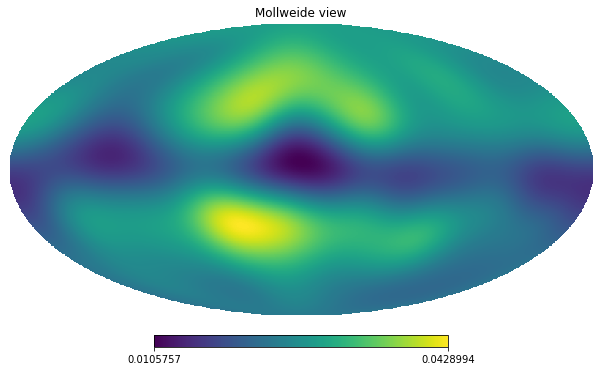

In [117]:
hp.mollview(smooth_z_maps[0])

### Get Correlation Data Points

corr-red:   
    $ \delta_{E_{B-V}} = E_{B-V} - E \left[ E_{B-V} \right] $
    <p> 
corr-bins[i]:   
    $ \delta_{r_i} = \frac{N}{<N> - 1} $

In [158]:
corr_red = dust_map - smooth_dust_map

# this array will hold delta_r for each zbin
corr_bins = []

# this array will be subtracted from <N> to create
# the denominator <N> - 1
ones_arr = np.ones(npixels)

for bin in tqdm(range(n_zbins)):
    # <N> - 1
    smooth_z_maps = np.subtract(smooth_z_maps[bin],ones_arr)
    # N / (<N> - 1)
    corr_bins.append(np.divide(z_maps[bin],smooth_z_maps[bin]))

100%|███████████████████████████████████████████| 26/26 [00:19<00:00,  1.34it/s]


### Create Naive Mask of Data

I applied a very naive mask to this data by slicing out a chunk that covers the galactic plane.

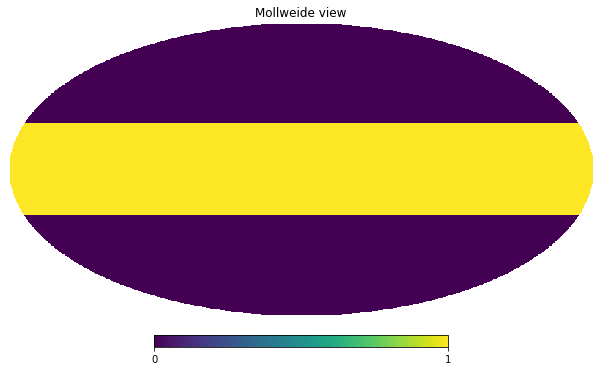

In [119]:
sample_mask = np.zeros(npixels)
sample_mask[15000000:35000000] = 1
hp.mollview(sample_mask)

In [120]:
mask_pix = np.arange(npixels)
mask_pix = [p for p in mask_pix if p < 15000000 or p > 35000000]
mask_corr_bins = []
mask_corr_red = corr_red[mask_pix]

for i in tqdm(range(len(corr_bins))):
    mask_corr_bins.append(corr_bins[i][mask_pix])

100%|███████████████████████████████████████████| 26/26 [00:35<00:00,  1.35s/it]


### Cross-Correlate

In [121]:
# store cross-correlation data
corr_data = np.zeros(len(corr_bins))
mask_corr_data = np.zeros(len(corr_bins))

for i in range(len(corr_bins)):
    corr_data[i] = np.correlate(corr_bins[i],corr_red)
    mask_corr_data[i] = np.correlate(mask_corr_bins[i],mask_corr_red)

### Contamination Results for D10 Model at 353GHz

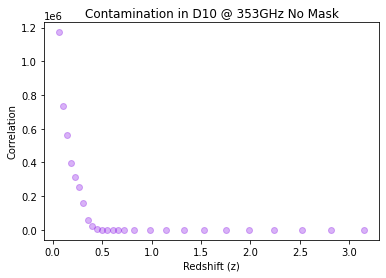

In [122]:
plt.scatter(z_bins,corr_data,color = (0.5,0.0,0.9,0.3))
plt.title('Contamination in D10 @ 353GHz No Mask')
plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.show()

### Contamination Results for D10 Model with Naive Mask

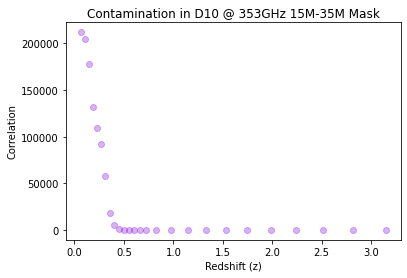

In [123]:
plt.scatter(z_bins,mask_corr_data,color = (0.5,0.0,0.9,0.3))
plt.title('Contamination in D10 @ 353GHz 15M-35M Mask')
plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.show()

### Compare These Results to Previous Results

This is not a great comparison for a few reasons: <p> 
    <li> When I originally ran the data I double corrected for noise (I subtracted the smoothed intensity map <b> and </b> subtracted the local mean) <p> <li> For the first data I did not run correlation data for every pixel in the dust map -- only the pixels with galaxies <p> <li> The first data was produced based on a dust intensity map at 343GHz and the most recent is based on a 353GHz dust intensity map.<ol>

In [127]:
# confine redshift to range[0,~0.5]
slice_z = z_bins[:11]
# truncate correlation data to same length
slice_cr = mask_corr_data[:11]

This is the data from the previous attempt to quantify the contamination 

In [128]:
datapoints = [45498.29856344,164398.46164576,281642.50384862,400619.07479296,489034.49531083,554949.76640514,614341.84802567,615200.41598952,613236.33898471,579935.57602181,552353.23261955,533164.05213498,543067.01045632,534086.57925103,499146.62133502,502957.70028926,576514.92755357,520709.53439014,414624.33564121,307950.38984074,207060.64284793,159544.3798582,112590.26340932,79014.860787,64763.89887758,41554.64758364,33900.98110298,13373.94732963,9929.62061345,5198.28877265,5595.34020391,2115.62276936]

# get redshift bins for x-axis
x1 = np.linspace(0,0.25,17)
x1 = x1[1:]
x2 = np.linspace(0.25,0.5,17)
x2 = x2[1:]
x = []
for i in range(len(x2)):
    x.append(x1[i])
    x.append(x2[i])
x.sort()

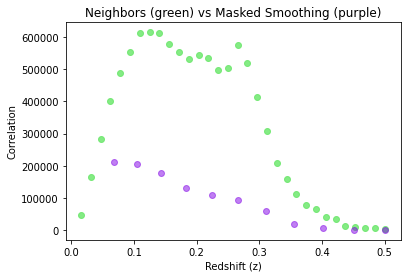

In [155]:
plt.scatter(x,datapoints,color=(0.4,0.9,0.4,0.8))
plt.scatter(slice_z,slice_cr,color = (0.5,0.0,0.9,0.5))
plt.title('Neighbors (green) vs Masked Smoothing (purple)')
plt.xlabel('Redshift (z)')
plt.ylabel('Correlation')
plt.show()